In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

import cleanlab
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold

from cleanlab.pruning import get_noise_indices

from pathlib import Path

import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


from pathlib import Path
from glob import glob

import numpy as np
from numpy import random
import tensorflow as tf
from sklearn.base import BaseEstimator

import cv2

from tqdm import tqdm
from tensorflow.python.keras.preprocessing import dataset_utils

import utils
from model import DataCentricClassifier

tf.random.set_seed(123)

In [2]:
experiment_dir = Path("../experiments/original/")
model_path = str(experiment_dir / "checkpoints" / "best_model")
dataset_dir = str(experiment_dir / "data" / "val")
image_paths, image_labels, class_names = utils.get_image_paths_and_labels(dataset_dir, shuffle=False, random_seed=None)

Found 813 files belonging to 10 classes.


In [3]:
classifier = DataCentricClassifier(
    model_path=model_path,
    image_paths=image_paths,
    image_labels=image_labels,
    class_names=class_names,
    batch_size=8,
    random_seed=123,
    epoch=1
)

Creating ResNet50 model...


In [4]:
train_size = len(image_paths)

In [5]:
X_train = np.arange(train_size)
y_train = image_labels

In [6]:
def estimate_confident_joint_and_cv_pred_proba(
        X,
        s,
        clf,
        cv_n_folds=5,
        thresholds=None,
        seed=None,
        calibrate=True,
):
    cleanlab.latent_estimation.assert_inputs_are_valid(X, s)
    # Number of classes
    K = len(np.unique(s))

    # Ensure labels are of type np.array()
    s = np.asarray(s)

    # Create cross-validation object for out-of-sample predicted probabilities.
    # CV folds preserve the fraction of noisy positive and
    # noisy negative examples in each class.
    kf = StratifiedKFold(n_splits=cv_n_folds, shuffle=True, random_state=seed)

    # Intialize psx array
    psx = np.zeros((len(s), K))

    # Split X and s into "cv_n_folds" stratified folds.
    for k, (cv_train_idx, cv_holdout_idx) in enumerate(kf.split(X, s)):
        clf.reset_weights()

        # Select the training and holdout cross-validated sets.
        X_train_cv, X_holdout_cv = X[cv_train_idx], X[cv_holdout_idx]
        s_train_cv, s_holdout_cv = s[cv_train_idx], s[cv_holdout_idx]

        # Fit the clf classifier to the training set and
        # predict on the holdout set and update psx.
        clf.fit(X_train_cv, s_train_cv)
        psx_cv = clf.predict_proba(X_holdout_cv)  # P(s = k|x) # [:,1]
        psx[cv_holdout_idx] = psx_cv

    # Compute the confident counts, a K x K matrix for all pairs of labels.
    confident_joint = cleanlab.latent_estimation.compute_confident_joint(
        s=s,
        psx=psx,  # P(s = k|x)
        thresholds=thresholds,
        calibrate=calibrate,
    )

    return confident_joint, psx

In [7]:
cj, psx = estimate_confident_joint_and_cv_pred_proba(X_train, y_train, clf=classifier)

Loading weights from ../experiments/original/checkpoints/best_model...
Filtered dataset size: 650
82/82 [==============================] - 5s 39ms/step - loss: 0.9859 - accuracy: 0.6646
Filtered dataset size: 163


100%|██████████| 163/163 [00:09<00:00, 16.86it/s]


Loading weights from ../experiments/original/checkpoints/best_model...
Filtered dataset size: 650
82/82 [==============================] - 3s 40ms/step - loss: 1.0409 - accuracy: 0.6169
Filtered dataset size: 163


100%|██████████| 163/163 [00:08<00:00, 19.72it/s]


Loading weights from ../experiments/original/checkpoints/best_model...
Filtered dataset size: 650
82/82 [==============================] - 3s 36ms/step - loss: 1.0171 - accuracy: 0.6600
Filtered dataset size: 163


100%|██████████| 163/163 [00:08<00:00, 19.76it/s]


Loading weights from ../experiments/original/checkpoints/best_model...
Filtered dataset size: 651
82/82 [==============================] - 3s 35ms/step - loss: 0.9972 - accuracy: 0.6590
Filtered dataset size: 162


100%|██████████| 162/162 [00:06<00:00, 24.93it/s]


Loading weights from ../experiments/original/checkpoints/best_model...
Filtered dataset size: 651
82/82 [==============================] - 3s 31ms/step - loss: 1.0428 - accuracy: 0.6375
Filtered dataset size: 162


100%|██████████| 162/162 [00:06<00:00, 25.17it/s]


In [8]:
cj, psx

(array([[55, 16,  0,  0,  2,  4,  0,  0,  0,  5],
        [ 1, 42, 10,  7,  2, 17,  1,  1,  0,  0],
        [ 0,  5, 26,  1,  0,  3, 14, 30,  0,  0],
        [ 2,  4,  1, 40,  4, 13,  9, 10,  1,  0],
        [ 1,  1,  0, 11, 50, 11,  1,  2,  0,  6],
        [ 0,  1,  1,  2,  1, 45, 21, 11,  0,  0],
        [ 0,  1,  1,  0,  0,  8, 34, 33,  0,  0],
        [ 0,  0,  0,  0,  0,  1, 15, 67,  0,  0],
        [ 3,  0, 10, 25,  1,  1, 11, 16, 14,  0],
        [ 1,  1,  0,  1,  3,  7,  3,  4,  0, 61]]),
 array([[9.95156109e-01, 2.55571562e-03, 1.02547001e-05, ...,
         6.47064837e-07, 4.91769060e-06, 3.33453674e-04],
        [6.08297348e-01, 2.33288124e-01, 4.43332084e-03, ...,
         8.66599090e-04, 8.42799636e-05, 5.09700039e-03],
        [8.80384862e-01, 1.04097072e-02, 4.36463539e-04, ...,
         4.67509351e-04, 4.24938371e-05, 4.24289610e-03],
        ...,
        [3.75428908e-06, 4.80828521e-06, 9.87020485e-07, ...,
         2.84391530e-02, 6.48316609e-06, 9.69988763e-01],
     

In [9]:
psx.shape

(813, 10)

In [10]:
est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(cj, y_train)

In [11]:
max_images = 32

noise_idx = cleanlab.pruning.get_noise_indices(y_train, psx, est_inv, prune_method='prune_by_class', confident_joint=cj)
print('Number of estimated errors in the dataset:', sum(noise_idx))

pred = np.argmax(psx, axis=1)
ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])[::-1]

# if sum(noise_idx) >= max_images:
prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

img_labels = ["given: "+str( class_names[label4viz[w]])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
img_preds = ["pred: "+str( class_names[pred4viz[w]])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]


Number of estimated errors in the dataset: 377


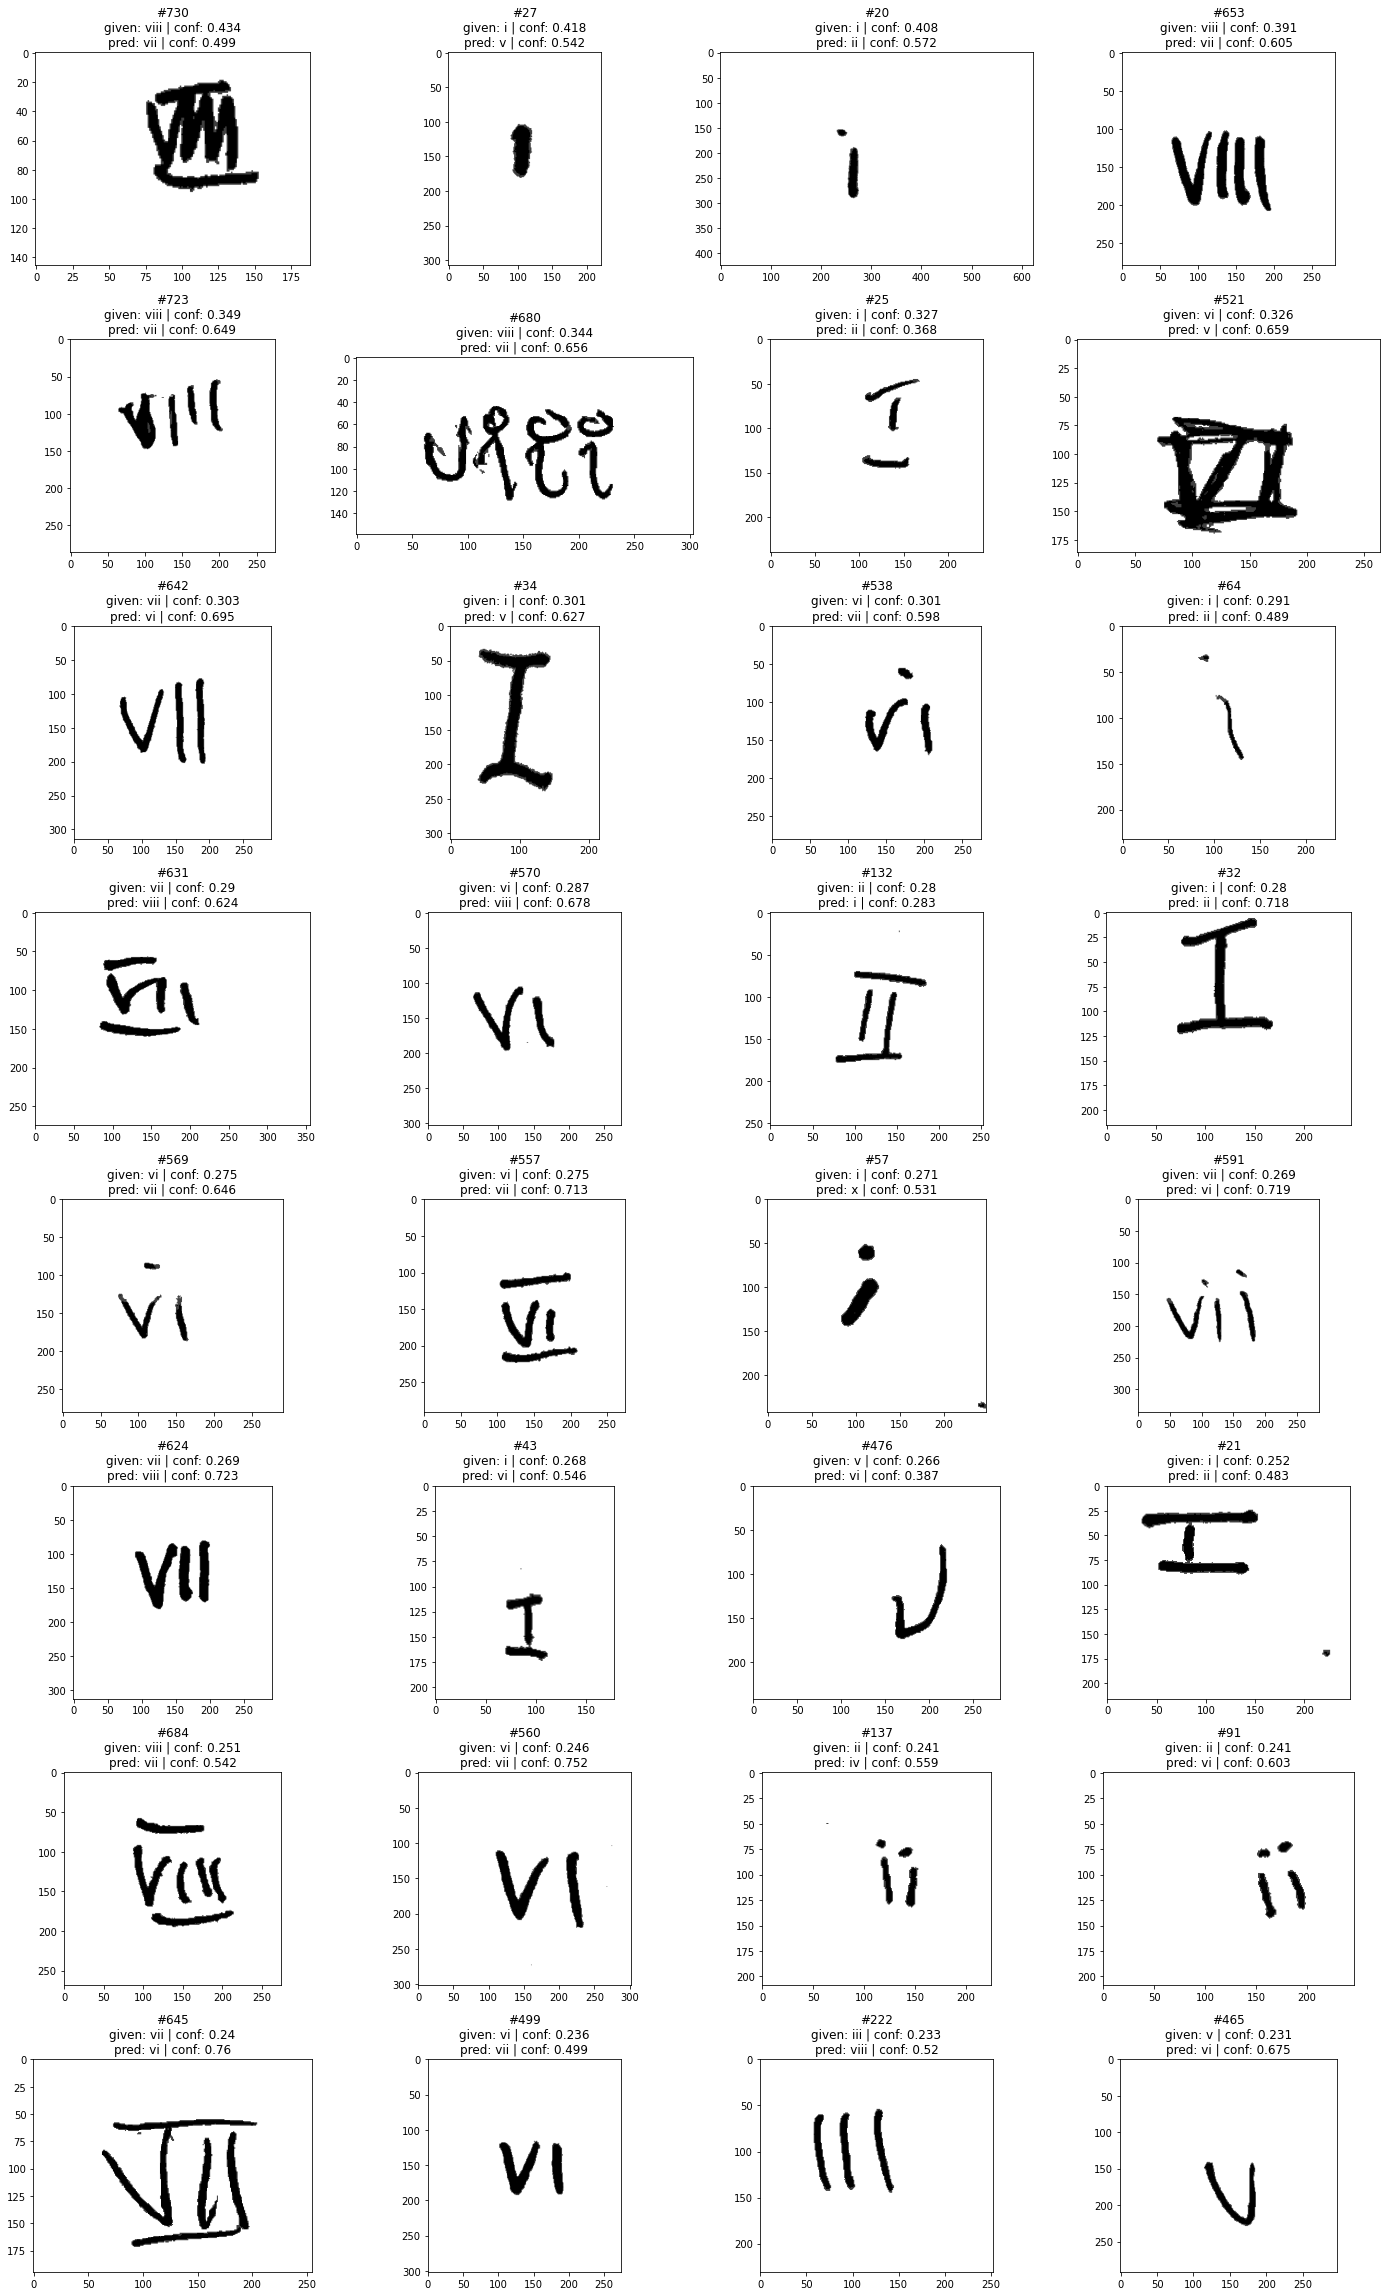

In [12]:
ncols = 4
nrows = int(np.ceil(len(img_labels) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_index, image_label, image_pred in zip(axes.ravel(), img_idx, img_labels, img_preds):
    image_path = image_paths[image_index]
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_index}\n{image_label}\n{image_pred}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()